In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale
)
from truth import IeeeGroundTruth
from wavelet import apply_wavelet


%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


class RppgMl:

    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', random_state = 0, kfold = True):
        
        self.data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.n_splits = len(data[subject_col].unique())
        self.random_state = random_state
        self.kfold_on = kfold

        self.X = self.data.drop(columns = [self.label_col, self.subject_col])
        self.y = self.data[self.label_col]

        self._scale_features()
        self._scale_targets()
        
        if self.kfold_on:
            self.groups = self.data[self.subject_col]
            self.gkf = GroupKFold(n_splits = self.n_splits)
            print(f'ML class initialized with {len(self.data[subject_col].unique())} subjects')

    def train_skl(self, model):
        
        self.skl_model = model
        
        if self.kfold_on:
            
            self.mse_scores = []
            for i, (train_index, test_index) in enumerate(self.gkf.split(self.X, self.y, self.groups)):
                print(f'Training on iteration {i}')
                
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                self.skl_model.fit(X_train, y_train)
                y_pred = self.skl_model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                self.mse_scores.append(mse)
        
        else:

            (
                self.X_train, self.X_test,
                self.y_train, self.y_test
            ) = train_test_split(self.X, self.y, test_size = 0.2, random_state = self.random_state)
            self.X_train = self.X_train.to_numpy()
            self.X_test = self.X_test.to_numpy()
            self.y_train = self.y_train.to_numpy()
            self.y_test = self.y_test.to_numpy()

            self.skl_model.fit(self.X_train, self.y_train)



    def predict_skl(self, x):
        return self.skl_model.predict(x)

    def eval_skl(self):
        if self.kfold_on:
            return np.mean(self.mse_scores), self.mse_scores
        
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))

    def feature_importances(self):
        importances = self.skl_model.feature_importances_
        feature_names = self.X.columns
        result = pd.DataFrame({'feature': feature_names, 'importance': importances})
        result = result.sort_values(by='importance', ascending=False)
        return result


    def _scale_features(self):

        # init the standard scaler
        self.features_scaler = StandardScaler()

        # get the training data as a numpy array
        xnp = self.X.to_numpy()
        
        # fit and transform the data
        self.features_scaler.fit(xnp)
        transformed_data = self.features_scaler.transform(xnp)

        # convert back to a dataframe
        self.X = pd.DataFrame(transformed_data, columns = self.X.columns)
    
    def _scale_targets(self):

        self.targets_scaler = StandardScaler()
        self.y = pd.DataFrame(self.targets_scaler.fit_transform(self.y.to_numpy().reshape(-1, 1)))


In [4]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    # truth.process_rgb()
    # truth.process_bvp()

    truths.append(truth)

In [5]:
# initialize csv to track model testing results
results = {'model': [], 'estimators': [], 'max_depth': [], 'wave': [], 'wavelet_level': [], 'mse': []}

In [26]:
wave_level = 1
wave = 'db2'

data_arr = []
for i in range(len(truths)):
    
    truth = truths[i]
    data = truth.preprocess_with_wavelet(wave = wave, level = wave_level)
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)
display(data.head())

rf100 = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf300 = RandomForestRegressor(n_estimators = 300, random_state = 0)
rf600 = RandomForestRegressor(n_estimators = 600, random_state = 0)
rf1000 = RandomForestRegressor(n_estimators = 1000, random_state = 0)
rf2000 = RandomForestRegressor(n_estimators = 2000, random_state = 0)

rf_mxd_12 = RandomForestRegressor(n_estimators = 300, max_depth = 12, random_state = 0)
xg300_no_max_depth = XGBRegressor(n_estimators=300)
xg1000_no_max_depth = XGBRegressor(n_estimators=1000)

xg100 = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg300 = XGBRegressor(n_estimators=300, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg600 = XGBRegressor(n_estimators=600, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg1000 = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

mls = {}
for name, model in [
    ('XG1000_NO_MAX_DEPTH', xg1000_no_max_depth)
    # ('RF100', rf100), ('RF300', rf300), ('rf600', rf600), ('rf1000', rf1000),
    # ('xg100', xg100), ('xg300', xg300), ('xg600', xg600), ('xg1000', xg1000)
]:
    
    ml = RppgMl(data.copy(), kfold = False)
    ml.train_skl(model)
    err = ml.eval_skl()
    feature_importances = ml.feature_importances()

    print(f'\n\nError for {name}: {err}')
    print(f'Feature importances for {name}: {feature_importances}')
    print()

    mls[name] = ml
    
    results['model'].append(name)
    results['estimators'].append(model.n_estimators)
    results['max_depth'].append(model.max_depth)
    results['wave'].append(wave)
    results['wavelet_level'].append(wave_level)
    results['mse'].append(err)


# ml = RppgMl(data, kfold = False)
# rf = RandomForestRegressor(n_estimators = 600, random_state = 0)
# rf2 = RandomForestRegressor(n_estimators=1000, max_depth=7)
# xg = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# ml.train_skl(rf)
# err = ml.eval_skl()
# feature_importances = ml.feature_importances()

# print(f'\n\nError: {err}')
# print(f'Feature importances: {feature_importances}')

,r,g,b,r_diff,g_diff,b_diff,bvp,subject
0,0.621000,0.499849,0.429788,0.209566,0.166498,0.118003,0.343589,1
1,0.590246,0.469633,0.399976,0.147601,0.110409,0.065852,0.342469,1
2,0.559496,0.439424,0.370172,0.085669,0.054357,0.013742,0.341467,1
3,0.562274,0.450098,0.386638,0.240661,0.251744,0.244353,0.340497,1
4,0.565050,0.460767,0.403097,0.395569,0.449024,0.474839,0.339521,1




Error for XG1000_NO_MAX_DEPTH: 0.08726888763406605
Feature importances for XG1000_NO_MAX_DEPTH:   feature  importance
2       b    0.460313
0       r    0.275907
5  b_diff    0.166587
1       g    0.050504
3  r_diff    0.025498
4  g_diff    0.021192



In [27]:
pd.DataFrame(results)

,model,estimators,max_depth,wave,wavelet_level,mse
0,RF100,100,NaN,db2,1,0.078149
1,RF300,300,NaN,db2,1,0.077403
2,rf600,600,NaN,db2,1,0.077146
3,rf1000,1000,NaN,db2,1,0.077011
4,xg100,100,7.0,db2,1,0.093295
5,xg300,300,7.0,db2,1,0.088545
6,xg600,600,7.0,db2,1,0.086330
7,xg1000,1000,7.0,db2,1,0.086179
8,RF2000,2000,NaN,db2,1,0.076969
9,RF_MXD_7,300,7.0,db2,1,0.128915


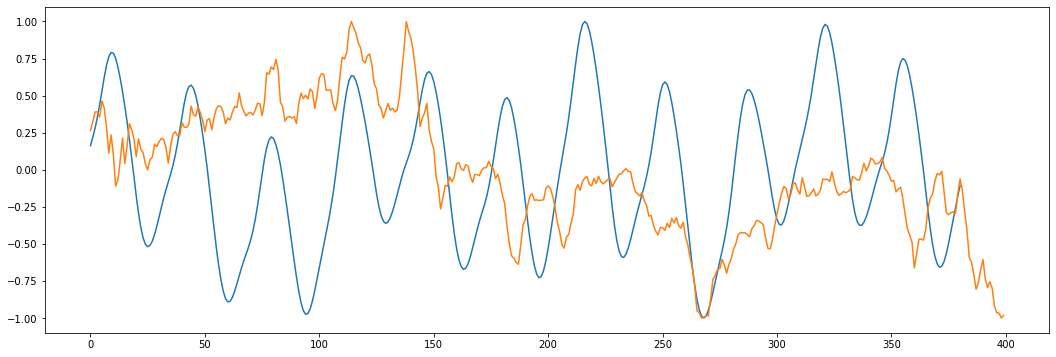

In [29]:
model = mls['XG1000_NO_MAX_DEPTH']

test_subject = 5
smoothing_window = 6
ground_truth_smoothing_window = 20
beg = 800
end = 1200

test_data = truths[test_subject - 1].preprocess_with_wavelet(wave = wave, level = wave_level)
test_X = test_data.drop(columns = ['bvp']).to_numpy()
test_y = test_data.bvp.to_numpy()

pred = model.predict_skl(test_X)
pred = n_moving_avg(pred, smoothing_window)
pred = resample(pred, len(test_y))
gt = test_y[beg: end]

signal = pred[beg: end]
gt = n_moving_avg(gt, ground_truth_smoothing_window)

signal = normalize_signal(signal)
signal = normalize_amplitude_to_1(signal)
gt = normalize_signal(gt)
gt = normalize_amplitude_to_1(gt)

plt.plot(gt)
plt.plot(signal)

### Try to apply pipeline methods now

In [ ]:
from scipy.signal import find_peaks, peak_prominences
def get_peaks(signal: np.ndarray, fr: int, max_freq: float, peak_height: float,
    slice_filter_thresh: int, perc1: float, perc2: float, prominence: float or None = None,
    with_min_dist: bool = True, with_additional_filtering: bool = True):
    """
    The current standard method for peak detection. Includes the option to use the _filter_peaks
    method for even more aggressive filtering.
    """
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    signal = signal[first_index: ]
    
    # apply a min distance if its given, otherwise just make it 1
    if with_min_dist:
        min_dist = fr // max_freq
    else:
        min_dist = 1
    
    # if prominence is None, make it 0
    if prominence is None:
        prominence = 0
    
    peaks, _ = find_peaks(signal, height = peak_height, prominence = prominence, distance = min_dist)

    if with_additional_filtering:
        peaks = _filter_peaks(signal, peaks, fr, slice_filter_thresh, perc1, perc2)
    
    prominences = {p + first_index: prom for p, prom in zip(peaks, peak_prominences(signal, peaks)[0])}
    return [p + first_index for p in peaks], prominences


def _filter_peaks(signal: np.ndarray, peaks: np.ndarray, fr: int,
    slice_filter_thresh: int, perc1: float, perc2: float):
    """
    Filter peaks with the intent of trying to peaks that are "definitely" noise.
    """

    # first, remove peaks that aren't sufficienrtly above the perc2 percentile. I intentionally
    # am comparing the peaks to the entire array, and not just the set of peaks, because I'm not
    # making the assumption that a certain percentage of peaks will inherently be noisy. However,
    # I am making the assumption that if the peak is insufficiently clear of a certain baseline of
    # the entire signal, then it must be noise.
    peaks = np.array([p for p in peaks if signal[p] >= np.percentile(signal, perc2)])   
    
    # Peak Walk: remove peaks that are close together, that aren't sufficiently large relative to the
    # entire signal. This percentile (perc1) is more stringent than the one used in the first step.
    for i in range(0, len(signal) - fr, fr):
        
        j = i + fr
        slce = peaks[(peaks >= i) & (peaks < j)]
        
        if len(slce) > slice_filter_thresh:
            to_remove = [i for i in range(len(slce)) if signal[slce[i]] < np.percentile(signal[slce], perc1)]
            peaks = peaks[~np.isin(peaks, [slce[i] for i in to_remove])]
            # removed += len(to_remove)
    
    return peaks

Number of true peaks: 11
Number of predicted peaks: 11


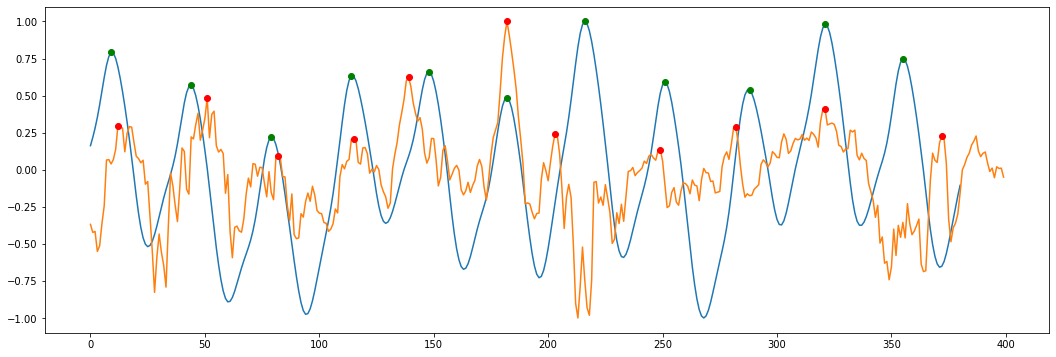

In [ ]:
peaks, _ = get_peaks(
    signal,
    64,
    3.0,
    -1,
    None,
    None,
    None,
    with_min_dist = True,
    with_additional_filtering = False,
    prominence = 0.3
)
true_peaks, _ = get_peaks(
    gt,
    64,
    3.0,
    -1,
    None,
    None,
    None,
    with_min_dist = True,
    with_additional_filtering = False,
    prominence = 0.2
)

plt.plot(gt)
plt.plot(signal)
plt.plot(peaks, signal[peaks], 'ro')
plt.plot(true_peaks, gt[true_peaks], 'go')

print(f'Number of true peaks: {len(true_peaks)}')
print(f'Number of predicted peaks: {len(peaks)}')


In [ ]:
from signal_pross import get_ibis, get_hr

true_ibis = get_ibis(true_peaks, 64)
true_hr = get_hr(true_ibis)
pred_ibis = get_ibis(peaks, 64)
pred_hr = get_hr(pred_ibis)

print('True HR:', true_hr)
print('Pred HR:', pred_hr)


True HR: 110.98265895953757
Pred HR: 106.66666666666667
